In [10]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor # Re-import after installation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
!pip install catboost

# Загрузка данных

In [12]:
train_data = pd.read_csv('diamonds_train.csv')
test_data = pd.read_csv('diamonds_test.csv')

# Подготовка данных для CatBoost

In [13]:
categorical_features = ['cut', 'color', 'clarity']
feature_cols = ['carat', 'depth', 'table', 'x', 'y', 'z'] + categorical_features
target_col = 'price'

X = train_data[feature_cols]
y = train_data[target_col]
X_test = test_data[feature_cols]


# Разделение на train/validation

In [14]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# CatBoost модель

In [15]:
catboost_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    cat_features=categorical_features,  # CatBoost сам обработает категории
    random_seed=42,
    verbose=100,
    eval_metric='RMSE',
    early_stopping_rounds=50
)

# Обучение

In [16]:
catboost_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    plot=True,
    use_best_model=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 3646.8312368	test: 3688.3032366	best: 3688.3032366 (0)	total: 119ms	remaining: 1m 58s
100:	learn: 578.5826163	test: 592.3102338	best: 592.3102338 (100)	total: 6.29s	remaining: 56s
200:	learn: 539.1638534	test: 570.3309211	best: 570.3309211 (200)	total: 15.6s	remaining: 1m 2s
300:	learn: 511.8675037	test: 559.9791109	best: 559.8929653 (299)	total: 23.7s	remaining: 55.1s
400:	learn: 491.4667685	test: 553.6050368	best: 553.5983931 (382)	total: 26.7s	remaining: 39.9s
500:	learn: 475.1548356	test: 552.1007294	best: 551.5125214 (488)	total: 30s	remaining: 29.9s
600:	learn: 462.5827847	test: 549.6396102	best: 549.5785447 (599)	total: 33.2s	remaining: 22s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 549.5785447
bestIteration = 599

Shrink model to first 600 iterations.


# Предсказание на validation

In [17]:
y_pred_cat = catboost_model.predict(X_val)

# Оценка модели

In [18]:
rmse_cat = np.sqrt(mean_squared_error(y_val, y_pred_cat))
r2_cat = r2_score(y_val, y_pred_cat)

print(f"CatBoost RMSE: {rmse_cat:.2f}")
print(f"CatBoost R²: {r2_cat:.4f}")

CatBoost RMSE: 549.58
CatBoost R²: 0.9813


# Предсказание на test данных

In [19]:
print("\nДелаем предсказания на test данных...")
test_predictions = catboost_model.predict(X_test)

print(f"Размер предсказаний: {len(test_predictions)}")
print(f"Примеры предсказаний: {test_predictions[:5]}")


Делаем предсказания на test данных...
Размер предсказаний: 5379
Примеры предсказаний: [4195.02935965 2468.08265794  717.46177849 1254.70507022  914.94217797]


# Создание submission файла

In [20]:
submission = pd.DataFrame({
    'id': test_data['id'],
    'price': test_predictions
})

# Проверка submission

In [21]:
print("\n=== ПРОВЕРКА SUBMISSION ФАЙЛА ===")
print(f"Размер submission: {submission.shape}")
print(f"Пропущенные значения в submission: {submission.isnull().sum().sum()}")
print(f"Минимальная цена: {submission['price'].min():.2f}")
print(f"Максимальная цена: {submission['price'].max():.2f}")
print(f"Средняя цена: {submission['price'].mean():.2f}")



=== ПРОВЕРКА SUBMISSION ФАЙЛА ===
Размер submission: (5379, 2)
Пропущенные значения в submission: 0
Минимальная цена: 203.10
Максимальная цена: 18500.90
Средняя цена: 3937.48


# Сохранение submission

In [22]:
submission_file = 'submission.csv'
submission.to_csv(submission_file, index=False)
print(f"\n✅ Submission файл сохранен как: {submission_file}")



✅ Submission файл сохранен как: submission.csv


# Анализ важности признаков

In [23]:
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': catboost_model.get_feature_importance()
}).sort_values('importance', ascending=False)

print("\n=== ВАЖНОСТЬ ПРИЗНАКОВ ===")
print(feature_importance)


=== ВАЖНОСТЬ ПРИЗНАКОВ ===
   feature  importance
4        y   26.192528
0    carat   21.746286
8  clarity   18.350572
7    color   11.777523
3        x   10.473926
5        z    9.901310
1    depth    0.583083
6      cut    0.511249
2    table    0.463523


# Визуализация важности признаков

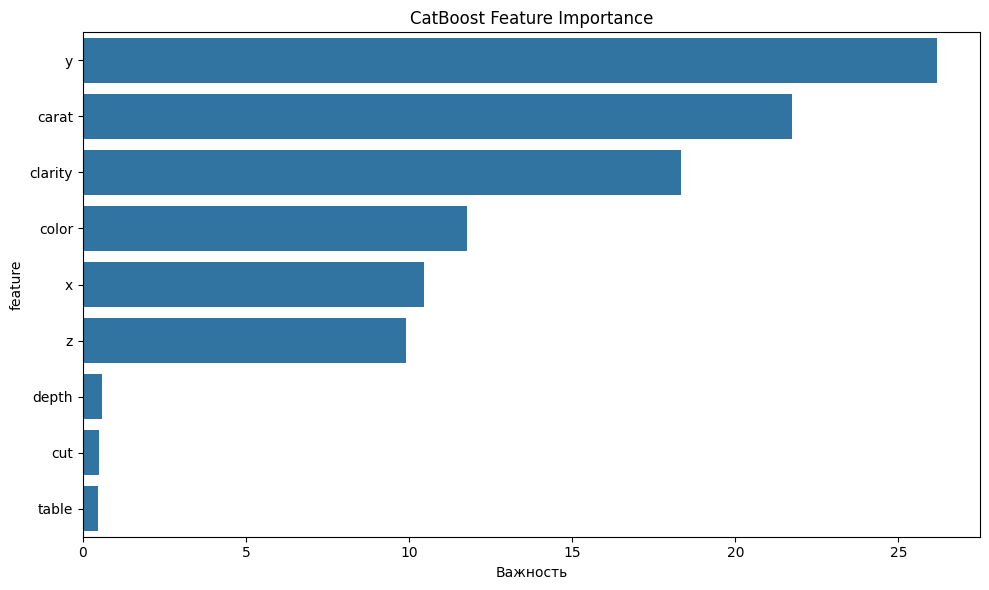

In [24]:
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('CatBoost Feature Importance')
plt.xlabel('Важность')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Дополнительная проверка распределения предсказаний

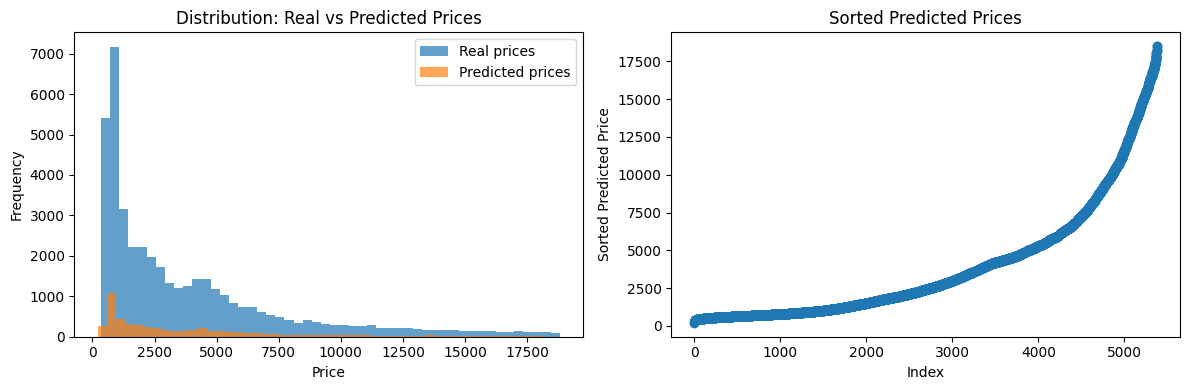

In [25]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(train_data['price'], bins=50, alpha=0.7, label='Real prices')
plt.hist(test_predictions, bins=50, alpha=0.7, label='Predicted prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution: Real vs Predicted Prices')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(range(len(test_predictions)), np.sort(test_predictions))
plt.xlabel('Index')
plt.ylabel('Sorted Predicted Price')
plt.title('Sorted Predicted Prices')

plt.tight_layout()
plt.savefig('predictions_analysis.png', dpi=300, bbox_inches='tight')
plt.show()